In [1]:
import wandb
wandb.init(project="pytorch-ignite-vae")

W&B Run: https://app.wandb.ai/evs/pytorch-ignite-vae/runs/she3vpop

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.dark_palette("purple"))
from sklearn.decomposition import PCA

In [3]:
import torch
from torch import nn
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader
import torch.nn.functional as F

from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.datasets import MNIST


from ignite.engine import Engine, Events
from ignite.metrics import MeanSquaredError, Loss, RunningAverage


from tqdm import tqdm

In [9]:
torch.manual_seed(7)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Variational Auto-encoders 101

In this exercise we will implement a variational auto-encoder (VAE). An auto-encoder encodes some input into a new and usually more compact representation which can be used to reconstruct the input data again. A VAE makes the assumption that the compact representation follows a probabilistic distribution (usually Gaussian) which makes it possible to sample new points and decode them into new data from a trained variational auto-encoder. The "variational" part comes from the fact that these models are training through variational inference.

The mathematical details of the training can be a bit challenging. However, we believe that probabilistic deep learning will be an important part of future machine learning, which is why we find it important to introduce the concepts.

As background material we recommend reading [Tutorial on Variational Autoencoder](http://arxiv.org/abs/1606.05908). For the implementation of the model you can read the article "Auto-Encoding Variational Bayes", Kingma & Welling, ICLR 2014: http://arxiv.org/pdf/1312.6114v10.pdf and "Stochastic Backpropagation and Approximate Inference in Deep Generative Models", Rezende et al, ICML 2014: http://arxiv.org/pdf/1401.4082v3.pdf.

## VAE crash course

Like the simple auto-encoder, VAEs consist of two parts as seen in the figure below where all arrows are non-linear mappings through a neural network. The two parts are the:

 * **Encoder** (also known as recognition, inference or Q-model): Maps the input data into a probabilistic latent space, z, by defining the mean and variance parameters of a Gaussian distribution as non-linear functions of the input data x like:
     - $q(z|x) = \mathcal{N}(z|\mu_\theta(x), \sigma_\phi(x))$, which is called the approximate posterior or latent distribution. The parameters $\mu_\theta(x)$ (mean) and $\log \sigma_\phi(x)^2$ (log-variance) are outputs from a hidden layer each.
 * **Decoder** (also known as generative, reconstruction or P-model): Conditioned on samples drawn from $z \sim q(z|x)$ in the encoder the input data is reconstructed through the: 
     - $p(x|z)$, which is the conditional likelihood (generative distribution). The choice of the generative distribution depends on the nature of the features, so for binary pixel values an appropiate choice of reconstruction distribution is the [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution), $p(x|z) = Ber(\mu_\phi(z)) = \mu_\phi(z)^x(1-\mu_\phi(z))^{1-k}$. $\mu_\phi(z)$ with $x=\{0,1\}$ is again the non-linear output of the last layer in the decoder. $\mu_\phi(z)$ is the probabilities of generating a 0 (black) or 1 (white) pixel value, like modelling 784 imbalanced coin-tossing processes. This is only possible because we assume the pixel intensities to be i.i.d. (Independent and Identically Distributed), so no direct correlations between them needs to modelled, even though we still achieve an indirect conditional correlation through the latent variables, z.
     
<img src="../static_files/VAE.png" alt="Drawing" style="width: 300px;"/>




In more mathematical details we can get the marginal likelihood for the features, e.g. binary pixel values, by integrating out the latent variable in the joint distribution:

$p(x) = \int_z p(x,z) dz = \int_z p(x|z)p(z)dz$

As a trick to introduce the approximate posterior, $q(z|x)$, which is more feasible to compute compared to our unknown true posterior, $p(z|x)$, we can always multiply and divide by $q(z|x)$ and move them around without changing anything:

$p(x) = \int_z p(x|z)p(z)\frac{q(z|x)}{q(z|x)}dz$


$p(x) = \int_z q(z|x) \frac{p(x|z)p(z)}{q(z|x)}dz$

Joint distributions can lead to underflow errors on a compute, so we instead try to maximize the log-likelihood  

$\log p(x) = \log \int_z q(z|x) \frac{p(x|z)p(z)}{q(z|x)}dz = \log \mathbb{E}_{q(z|x)}\left[\frac{p(x|z)p(z)}{q(z|x)}\right]$

where we used that the integral is just the expectation (mean) wrt. $q(z|x)$ and in this case the $\log$ can be moved inside the expectation by applying [Jensen's inequality](https://en.wikipedia.org/wiki/Jensen%27s_inequality):

$\log p(x) \geq  \int_z q(z|x)\log \frac{p(x|z)p(z)}{q(z|x)}dz =  \mathbb{E}_{q(z|x)}\left[\log \frac{p(x|z)p(z)}{q(z|x)}\right] = \mathcal{L}(x)$

This, $\mathcal{L}(x)$, is denoted the variational lower bound or evidence lower bound objective (ELBO). It is a lower bound to the log-likelihood and a tradeoff with the Kullback-Leibler divergence, $KL[q(z|x) || p(z|x)]$, between the approximate and true posterior, which we threw away when applying Jensen's inequality. This tradeoff is more easily understood through the derivation in the end of the notebook, so read it if you have the time. 

Like with Pokemons, there is a whole range of families of distributions to choose from, but we choose the most common one describing symmetric variations around a mean in signals with noise, the normal distribution:

$q(z|x) = \mathcal{N}(z|\mu_\theta(x), \sigma_\phi(x)I)$

and a simple isotropic normal distribution as the latent prior

$p(z) = \mathcal{N}(z|0, I)$

which becomes the part of the important regularising KL-term, when splitting up the lower bound as

$\mathcal{L}(x) = \mathbb{E}_{q(z|x)} \left[\log p(x|z)\right] - \mathbb{E}_{q(z|x)}\left[\log \frac{q(z|x)}{p(z)}\right] = \mathbb{E}_{q(z|x)} \left[\log p(x|z)\right] - KL[q(z|x) || p(z)]$

This is the function that we need to maximise, by minimising the negative lower bound. Here the first term on the R.H.S. is the data reconstruction and the second term the Kullback-Leibler divergence between the approximate and true posterior distributions which acts as a probabilistic regularizer forcing $q(z|x)$ to be close to having zero mean and identity variance, like $p(z)$. The KL-term can calculated analytically and the reconstruction error, $\log p(x|z)$, is just the binary cross-entropy.

### Training a VAE 
The VAE is similar to a deterministic autoencoder (1.Auto_Encoders) except that we assume that the latent units follows a distribution. Usually we just assume that the units are independent standard normally distributed (i.i.d.).

Above we defined a lower bound on the log-likelihood of the data. We can train the model by maximising the lower bound w.r.t. the model parameters, weight matrices, through the stochastic gradient descent algorithm.  Feasible approximations of the expectations in the lower bound, $\mathcal{L}(x)$, are obtained by evaluating the inside with samples drawn from the latent distribution, $z \sim q(z|x) = \mathcal{N}(z|\mu_\theta(x), \sigma_\phi(x)I)$ and dividing by the number of samples drawn. By using the _reparameterization trick_, $ \mu_\theta(x) + \sigma_\phi(x) \cdot \epsilon$, for the sampling procedure we can directly backpropogate gradients through the latent bottleneck and optimize the parameters w.r.t. the lower bound. 

## MNIST
First let us load the MNIST dataset and plot a few examples. We only load a limited amount of classes, controlled through the `classes` variable, to speed up training.

len(train_data) :  60000
len(val_data) :  10000
image.shape :  torch.Size([1, 28, 28])
label :  5


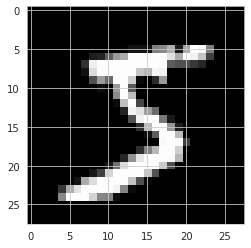

In [7]:
data_transform = Compose([ToTensor()])

train_data = MNIST(download=True, root="/tmp/mnist/", transform=data_transform, train=True)
val_data = MNIST(download=True, root="/tmp/mnist/", transform=data_transform, train=False)

image = train_data[0][0]
label = train_data[0][1]

print ('len(train_data) : ', len(train_data))
print ('len(val_data) : ', len(val_data))
print ('image.shape : ', image.shape)
print ('label : ', label)

img = plt.imshow(image.squeeze().numpy(), cmap='gray')

### Building the model
When defining the model the latent layer must act as a bottleneck of information, so that we ensure that we find a strong internal representation. We initialize the VAE with 1 hidden layer in the encoder and decoder using relu units as non-linearity.

In [10]:
kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {}

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, **kwargs)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True, **kwargs)

for batch in train_loader:
    x, y = batch
    break

print ('x.shape : ', x.shape)
print ('y.shape : ', y.shape)


x.shape :  torch.Size([32, 1, 28, 28])
y.shape :  torch.Size([32])


In [ ]:
import torch.nn as nn
from torch.nn.functional import softplus

# define size variables
num_features = 28**2

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_features, num_samples):
        super(VariationalAutoencoder, self).__init__()
        
        self.latent_features = latent_features
        self.num_samples = num_samples

        # We encode the data onto the latent space using two linear layers
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            # A Gaussian is fully characterised by its mean and variance
            nn.Linear(in_features=64, out_features=2*self.latent_features) # <- note the 2*latent_features
        )
        
        # The latent code must be decoded into the original image
        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.latent_features, out_features=64),
            nn.LeakyReLU(),
            nn.Linear(in_features=64, out_features=128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=num_features)
        )
        

    def forward(self, x): 
        outputs = {}
        
        # Split encoder outputs into a mean and variance vector
        mu, log_var = torch.chunk(self.encoder(x), 2, dim=-1)
        
        # :- Reparametrisation trick
        # a sample from N(mu, sigma) is mu + sigma * epsilon
        # where epsilon ~ N(0, 1)
                
        # Don't propagate gradients through randomness
        with torch.no_grad():
            batch_size = mu.size(0)
            epsilon = torch.randn(batch_size, self.num_samples, self.latent_features)
            
            if cuda:
                epsilon = epsilon.cuda()
        
        sigma = torch.exp(log_var/2)
        
        # We will need to unsqueeze to turn
        # (batch_size, latent_dim) -> (batch_size, 1, latent_dim)
        z = mu.unsqueeze(1) + epsilon * sigma.unsqueeze(1)        
        
        # Run through decoder
        x = self.decoder(z)
        
        # The original digits are on the scale [0, 1]
        x = torch.sigmoid(x)
        
        # Mean over samples
        x_hat = torch.mean(x, dim=1)
        
        outputs["x_hat"] = x_hat
        outputs["z"] = z
        outputs["mu"] = mu
        outputs["log_var"] = log_var
        
        return outputs


latent_features = 10
num_samples = 10

net = VariationalAutoencoder(latent_features, num_samples)

# Transfer model to GPU if available
if cuda:
    net = net.cuda()

print(net)

In [11]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


Following we define the PyTorch functions for training and evaluation.

In [13]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

def kld_loss(x_pred, x, mu, logvar):
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

bce_loss = nn.BCELoss(reduction='sum')

Test the forward pass, to check that everything is in order.

In [16]:
def process_function(engine, batch):
    model.train()
    optimizer.zero_grad()
    x, _ = batch
    x = x.to(device)
    x = x.view(-1, 784)
    x_pred, mu, logvar = model(x)
    BCE = bce_loss(x_pred, x)
    KLD = kld_loss(x_pred, x, mu, logvar)
    loss = BCE + KLD
    loss.backward()
    optimizer.step()
    return loss.item(), BCE.item(), KLD.item()


def evaluate_function(engine, batch):
    model.eval()
    with torch.no_grad():
        x, _ = batch
        x = x.to(device)
        x = x.view(-1, 784)
        x_pred, mu, logvar = model(x)
        kwargs = {'mu': mu, 'logvar': logvar}
        return x_pred, x, kwargs


trainer = Engine(process_function)
evaluator = Engine(evaluate_function)
training_history = {'bce': [], 'kld': [], 'mse': []}
validation_history = {'bce': [], 'kld': [], 'mse': []}


In [17]:
RunningAverage(output_transform=lambda x: x[0]).attach(trainer, 'loss')
RunningAverage(output_transform=lambda x: x[1]).attach(trainer, 'bce')
RunningAverage(output_transform=lambda x: x[2]).attach(trainer, 'kld')

In [19]:
MeanSquaredError(output_transform=lambda x: [x[0], x[1]]).attach(evaluator, 'mse')
Loss(bce_loss, output_transform=lambda x: [x[0], x[1]]).attach(evaluator, 'bce')
Loss(kld_loss).attach(evaluator, 'kld')

In [20]:
MeanSquaredError(output_transform=lambda x: [x[0], x[1]]).attach(evaluator, 'mse')
Loss(bce_loss, output_transform=lambda x: [x[0], x[1]]).attach(evaluator, 'bce')
Loss(kld_loss).attach(evaluator, 'kld')

In [22]:
def print_logs(engine, dataloader, mode, history_dict):
    evaluator.run(dataloader, max_epochs=1)
    metrics = evaluator.state.metrics
    avg_mse = metrics['mse']
    avg_bce = metrics['bce']
    avg_kld = metrics['kld']
    avg_loss =  avg_bce + avg_kld
    print(
        mode + " Results - Epoch {} - Avg mse: {:.2f} Avg loss: {:.2f} Avg bce: {:.2f} Avg kld: {:.2f}"
        .format(engine.state.epoch, avg_mse, avg_loss, avg_bce, avg_kld))
    for key in evaluator.state.metrics.keys():
        history_dict[key].append(evaluator.state.metrics[key])

trainer.add_event_handler(Events.EPOCH_COMPLETED, print_logs, train_loader, 'Training', training_history)
trainer.add_event_handler(Events.EPOCH_COMPLETED, print_logs, val_loader, 'Validation', validation_history)

Using more samples gives us a better approximation of the expectation, and consequently a better approximation of the lower bound. The reconstructed image is generated by taking the mean over the samples.

## Optional exercises

- OPT: Use the original paper http://arxiv.org/pdf/1312.6114v10.pdf or [this blog](http://blog.shakirm.com/2015/10/machine-learning-trick-of-the-day-4-reparameterisation-tricks/) to explain what the reparameterization trick does.
- OPT: Look through https://arxiv.org/abs/1611.00712 or https://arxiv.org/abs/1611.01144 and explain how one could instead introduce a categorical latent variable for $z$.
- OPT: Implement the Gumbel softmax trick thereby letting $z$ take a categorical distribution.
- OPT: The VAE is a probablistic model. We could model $p(x,z,y)$ where $y$ is the label information. Explain how this model could handle semi-supervised learning? You can look through the papers https://arxiv.org/pdf/1406.5298.pdf or  https://arxiv.org/pdf/1602.05473v4.pdf or again the two papers on Gumbel softmax.

**Answers**: